In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold , cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import xgboost as xgb


In [ ]:
!unzip "/content/csc462-connect-4.zip" -d "/content/"

Archive:  /content/csc462-connect-4.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
  inflating: /content/val.csv        


In [ ]:
testdata = pd.read_csv("/content/test.csv")
traindata = pd.read_csv("/content/train.csv")
valdata = pd.read_csv("/content/val.csv")

In [ ]:
def create_features(df_original):
    df = df_original.copy()

    feat_cols = [f"p{i}" for i in range(1, 43)]
    X = df[feat_cols].to_numpy()

    boards = X.reshape(-1, 6, 7)

    heights = (boards != 0).sum(axis=1)
    full = (heights == 6)

    df["center_open"] = (heights[:, 3] < 6)
    for j in range(7):
        df[f"h{j+1}"] = heights[:, j]
        df[f"full_c{j+1}"] = full[:, j]
    return df

BOARD = [f"p{i}" for i in range(1, 43)]

def normalize(df):
    out = df.copy()
    B = out[BOARD].to_numpy(dtype="int8")
    t = out["turn"].to_numpy(dtype="int8")    # ±1
    out[BOARD] = (B * t[:, None]).astype("int8")
    out["turn"] = 1
    return out



In [ ]:
#Data Split x, y
#--------------Encoding ---------------
train_featured = normalize(create_features(traindata))

valid_featured = normalize(create_features(valdata))
test_featured = normalize(create_features(testdata))

for col in train_featured.select_dtypes('bool').columns:
    train_featured[col] = train_featured[col].astype(int)

for col in valid_featured.select_dtypes('bool').columns:
    valid_featured[col] = valid_featured[col].astype(int)

for col in test_featured.select_dtypes('bool').columns:
    test_featured[col] = test_featured[col].astype(int)

X_train = train_featured.drop('label_move_col', axis=1)
y_train = train_featured['label_move_col']

X_valid = valid_featured.drop('label_move_col', axis=1)
y_valid = valid_featured['label_move_col']

if "id" in test_featured.columns:
    X_test = test_featured.drop("id", axis=1)
else:
    X_test = test_featured
print(X_train.head())


#------------non encocded split-------------
train_x = traindata.drop(columns=['label_move_col'])
train_y = traindata['label_move_col']
val_x = valdata.drop(columns=['label_move_col'])
val_y = valdata['label_move_col']
test_x = testdata.drop(columns=['id'])


   p1  p2  p3  p4  p5  p6  p7  p8  p9  p10  ...  h3  full_c3  h4  full_c4  h5  \
0   0   1  -1   1  -1   0   1   0   1   -1  ...   2        0   1        0   2   
1   0   1   1  -1   0   0   0   0  -1    0  ...   1        0   2        0   0   
2   0  -1   1  -1   0   0  -1   0   0    1  ...   2        0   1        0   0   
3  -1   0   0   0   1  -1  -1   1   0    0  ...   0        0   0        0   2   
4  -1  -1   1   1   1  -1   1  -1   0    0  ...   1        0   2        0   1   

   full_c5  h6  full_c6  h7  full_c7  
0        0   0        0   1        0  
1        0   0        0   0        0  
2        0   0        0   1        0  
3        0   1        0   2        0  
4        0   4        0   6        1  

[5 rows x 58 columns]


In [ ]:



dtr = xgb.DMatrix(X_train, label=y_train)
dva = xgb.DMatrix(X_valid, label=y_valid)

# ---- 3) Parameters (multiclass) --------------------------------------------
num_class = 7
params = {
    "objective": "multi:softprob",   # probabilities over 7 classes
    "num_class": num_class,
    "eval_metric": "merror",         # multiclass error
    "eta": 0.05,                     # learning_rate
    "max_depth": 7,
    "min_child_weight": 2,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "reg_lambda": 2.0,
    "tree_method": "hist",
    # Optional: if you have a strong first-player bias, a neutral prior helps
    "base_score": 1.0/num_class,     # safe prior for softmax
}

# ---- 4) Early stopping via CV (version-proof) -------------------------------
cv = xgb.cv(
    params=params,
    dtrain=dtr,
    num_boost_round=3000,
    nfold=5,
    early_stopping_rounds=80,
    seed=42,
    stratified=True,
    verbose_eval=False,
)

best_rounds = len(cv)
print("Best rounds:", best_rounds)

# ---- 5) Train final booster -------------------------------------------------
bst = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=best_rounds
)

# ---- 6) Validate ------------------------------------------------------------
probs = bst.predict(dva)             # shape: (n_valid, 7)
preds = probs.argmax(axis=1)
acc = accuracy_score(y_valid, preds)
print("Validation accuracy:", acc)



Best rounds: 1034
Validation accuracy: 0.6367180248746983


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# y_valid: ground-truth labels for the validation set (same encoding as preds)
labels = list(range(7))               # or: labels = le.classes_.tolist()
cm = confusion_matrix(y_valid, preds, labels=labels)
print(cm)

# Optional: normalized by true class (recall per row)
cm_norm = confusion_matrix(y_valid, preds, labels=labels, normalize='true')
print(cm_norm.round(3))

# Helpful summary metrics
print(classification_report(y_valid, preds, labels=labels, digits=3))


[[ 638   57   71  315   85   63  221]
 [  58  502   34  177   45   46   63]
 [  67   34  582  164   52   39   95]
 [ 136   72   59 3425   60   65  141]
 [  92   39   56  170  577   32   67]
 [  61   46   44  186   29  494   65]
 [ 227   60   83  304   72   62  642]]
[[0.44  0.039 0.049 0.217 0.059 0.043 0.152]
 [0.063 0.543 0.037 0.191 0.049 0.05  0.068]
 [0.065 0.033 0.563 0.159 0.05  0.038 0.092]
 [0.034 0.018 0.015 0.865 0.015 0.016 0.036]
 [0.089 0.038 0.054 0.165 0.559 0.031 0.065]
 [0.066 0.05  0.048 0.201 0.031 0.534 0.07 ]
 [0.157 0.041 0.057 0.21  0.05  0.043 0.443]]
              precision    recall  f1-score   support

           0      0.499     0.440     0.468      1450
           1      0.620     0.543     0.579       925
           2      0.626     0.563     0.593      1033
           3      0.722     0.865     0.787      3958
           4      0.627     0.559     0.591      1033
           5      0.617     0.534     0.572       925
           6      0.496     0.443     

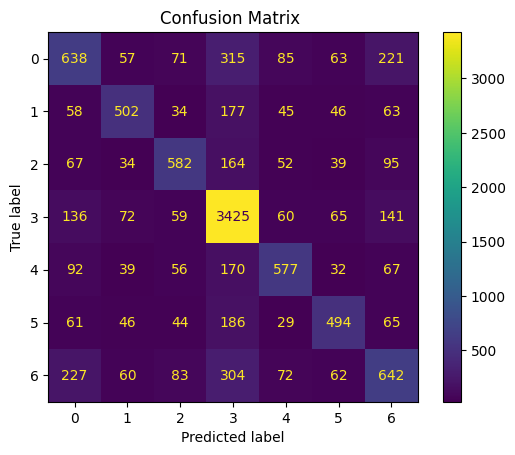

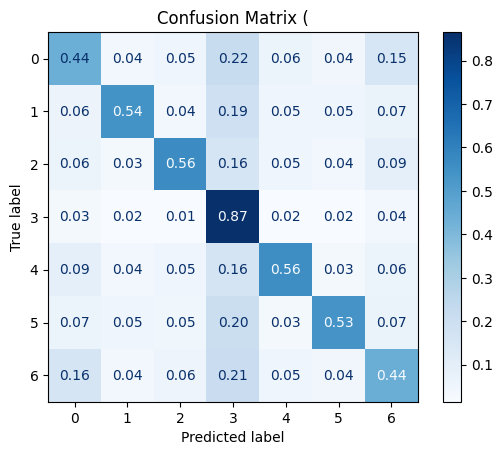

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='d')          # or values_format='.2f' for normalized cm
plt.title("Confusion Matrix ")
plt.show()



In [ ]:
X_test_processed = prep_X(X_test)
dte = xgb.DMatrix(X_test_processed)
probsX = bst.predict(dte)             # shape: (n_valid, 7)
predsX = probsX.argmax(axis=1)

In [ ]:
submit = pd.DataFrame({'id':testdata['id'],'label_move_col':predsX})

submit.to_csv('SubmissionXG.csv',index=False)